In [167]:
import config
import sqlalchemy
import functions
import statsapi as mlb
import sql_alch_schema
from datetime import datetime

from sqlalchemy.ext.declarative import declarative_base
from sqlalchemy import Column, Integer, String,DateTime,Date,Time,Boolean,func
from sqlalchemy import ForeignKey,and_
from sqlalchemy.orm import relationship
from sqlalchemy.schema import Table
from sqlalchemy import distinct

_sql_alchemy_connection = (
                                f'mysql+mysqlconnector://'
                                f'{config.user}:{config.password}'
                                f'@{config.host}:{config.port}'
                                f'/{config.schema}'
                           )
## Create the engine 
db = sqlalchemy.create_engine(_sql_alchemy_connection,
                              echo = False,
                              connect_args = {'ssl_disabled' : True,})

Base = sql_alch_schema.Base

Game = sql_alch_schema.Game
Play = sql_alch_schema.Play
Team = sql_alch_schema.Team
GameTeamLink = sql_alch_schema.GameTeamLink
Person = sql_alch_schema.Person


from sqlalchemy.orm import sessionmaker
Session = sessionmaker(bind=db)
session = Session()

#Base.metadata.create_all(db)

import sqlalchemy_schemadisplay
from sqlalchemy import MetaData

schema_viz = sqlalchemy_schemadisplay.create_schema_graph(metadata=MetaData(db))
schema_viz.write_png('dbschema.png')

import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import numpy as np
sns.set_style('whitegrid')
%config InlineBackend.figure_format = 'retina'

sns.set(color_codes=True)
sns.set(rc={'figure.figsize':(12,10)})

In [168]:
image_dir = "/Users/schlinkertc/code/mlb_predictions/mlb_predictions/images/"

## What's in our DB?


The yankees played the mets on my birthday, so obviously we're gonna look at that game

In [169]:
yankees = session.query(Team).filter(Team.teamName=='Yankees').one()
yankees.id

147

In [170]:
june_11 = datetime(2019,6,11)
yankees_mets6_11 = (session.query(Game)
                    .order_by(Game.dateTime.asc())
                    .filter(and_(Game.dateTime>june_11,
                                 Game.homeTeam_id==yankees.id))
                    .first())

In [171]:
yankees_mets6_11

<Game(pk='567491',id='2019/06/11/nynmlb-nyamlb-1')>

In [172]:
# we won!
home_score = max([x.homeScore for x in yankees_mets6_11.plays])
away_score = max([x.awayScore for x in yankees_mets6_11.plays])
print(home_score,away_score)

12 5


## Import Dataset

In [203]:
df = pd.read_csv('dataset.csv')
df.shape

(1531, 111)

In [202]:
def merge_scores(df,session):
    """
    Takes in a dataframe and a sql alch session, returns df with game scores added. merges with 'ID' column.
    """
    games = [session.query(Game).filter(Game.id==x).one() for x in df['ID']]

    score_dict=([{'ID':g.id,
                  'home_score':max([x.homeScore for x in g.plays]),
                  'away_score':max([x.awayScore for x in g.plays])} 
                  for g in games])

    df=pd.merge(right=pd.DataFrame.from_dict(score_dict),
            left=df,
            right_on='ID',
            left_on='ID')
    return df

In [ ]:
df = merge_scores(df,session)

In [175]:
# df['home_score']=(df.apply(
#     lambda x: 
#     max([x.homeScore for x in session.query(Game)
#          .filter(Game.id==x['ID']).one().plays]),axis=1))

In [176]:
df.fillna(0,inplace=True)

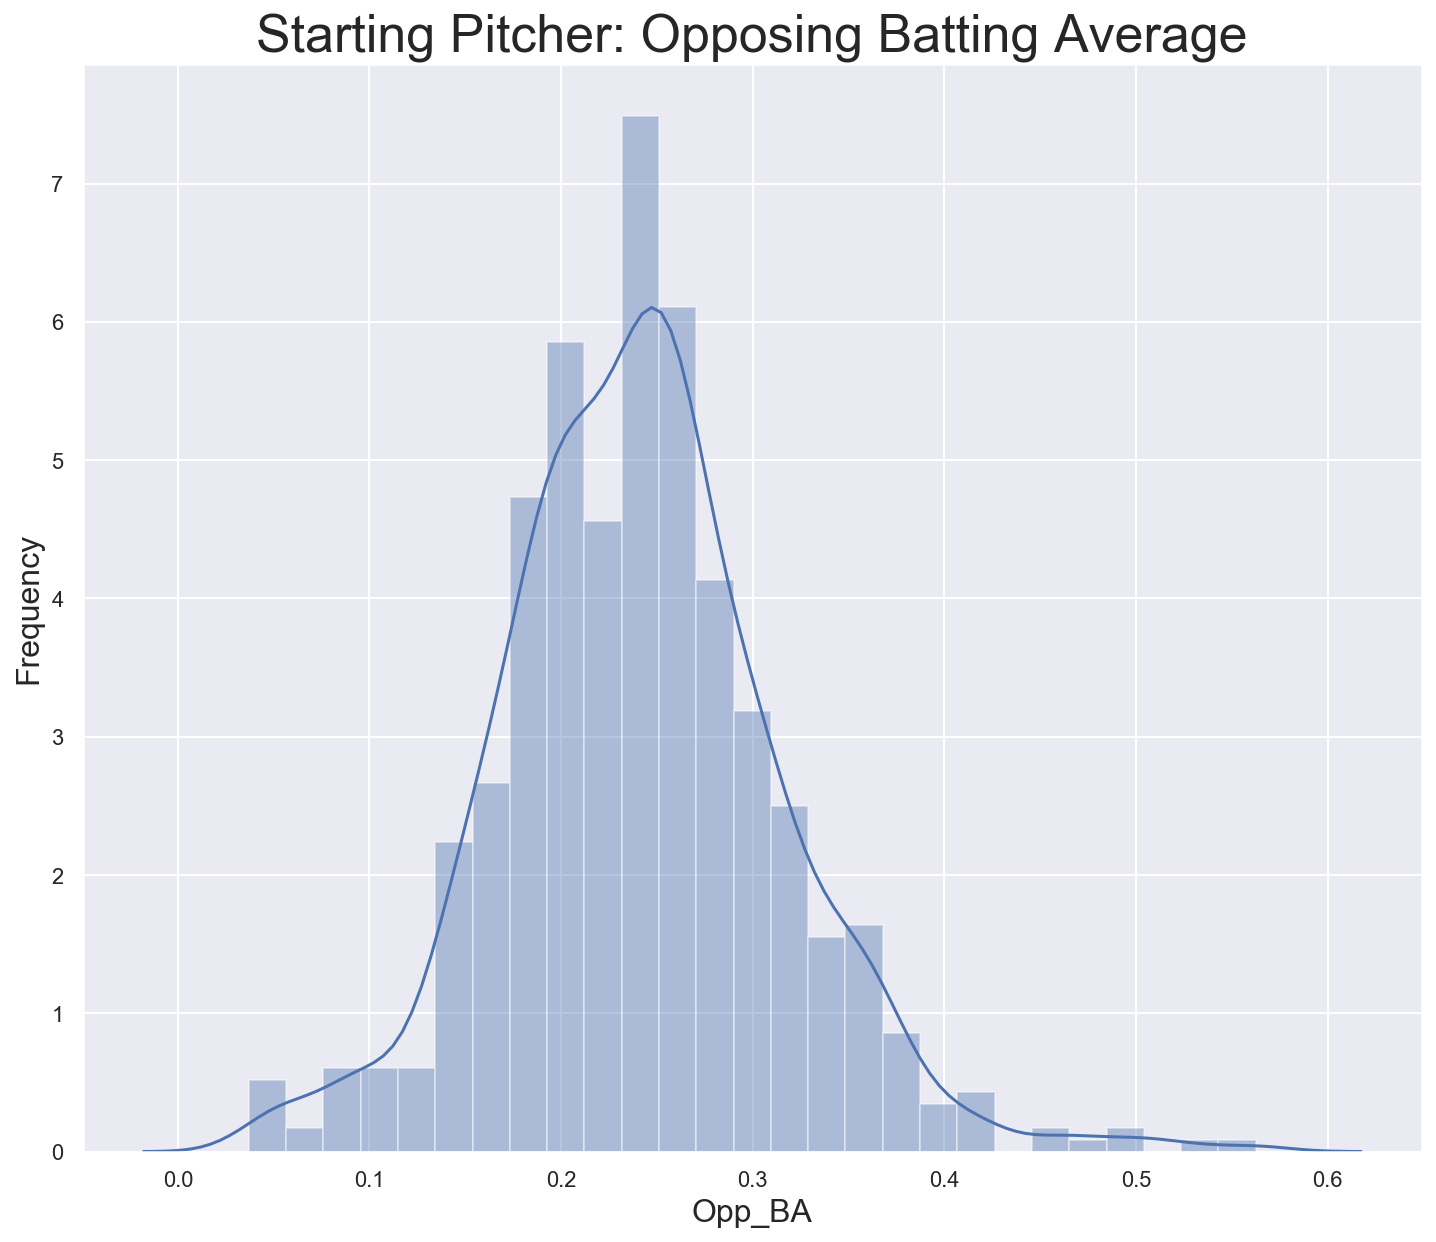

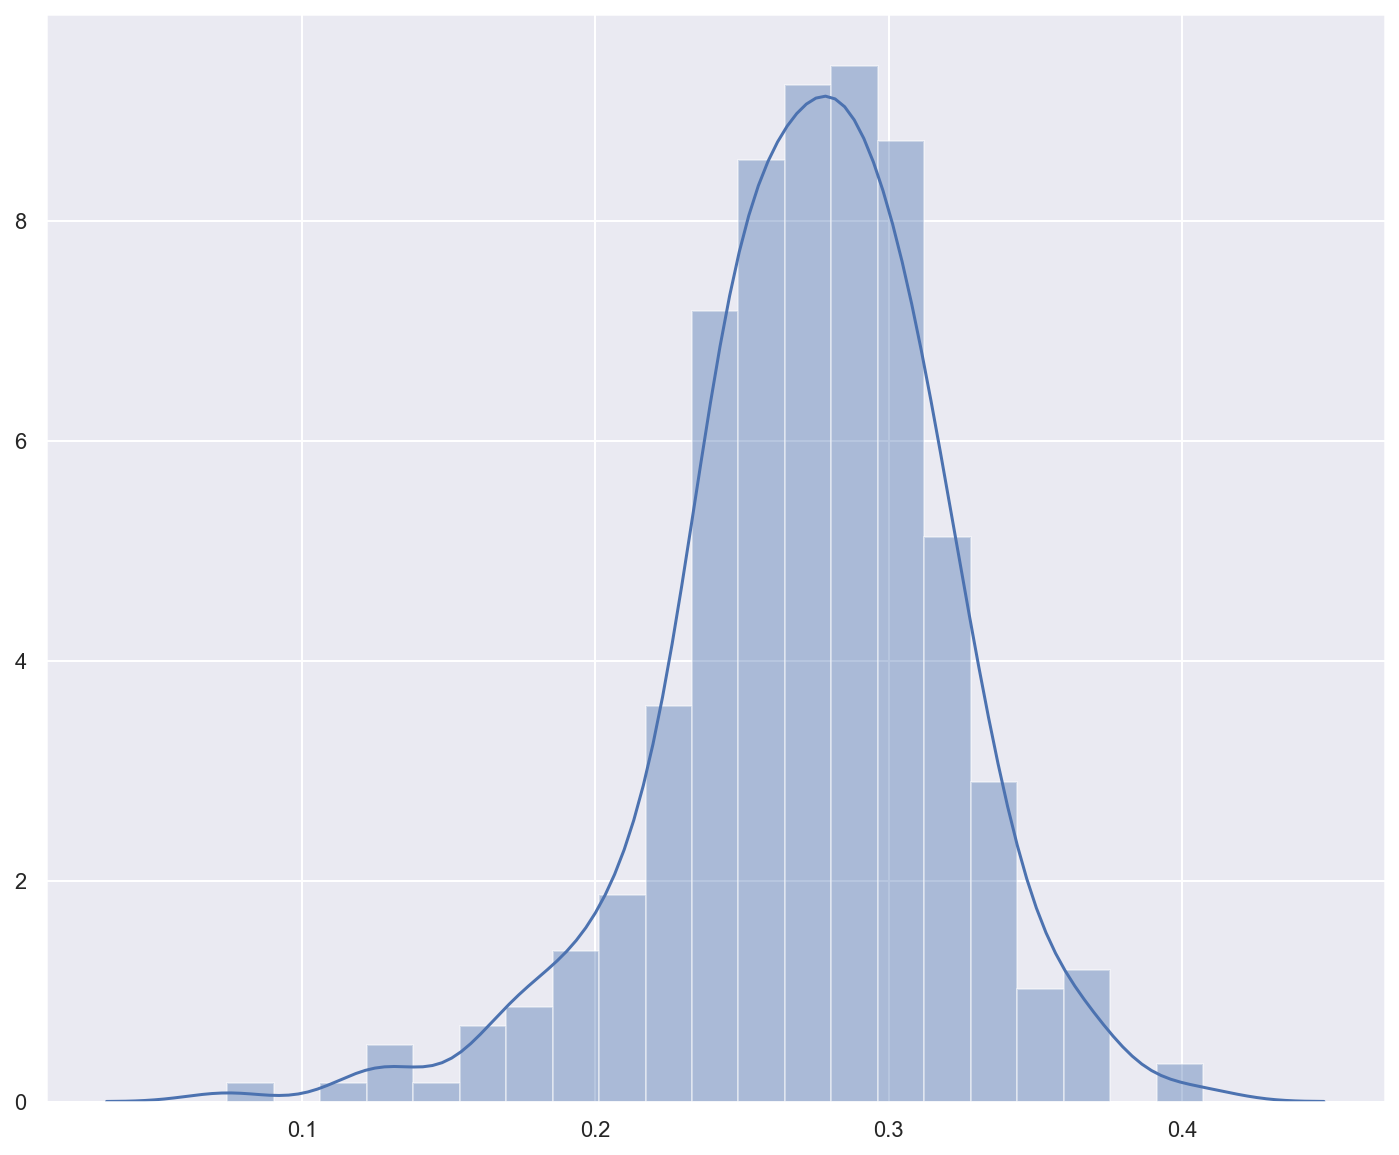

In [177]:
nonZero_homeStarterBa=[x for x in df['home_starter_BA'] if x>0]
nonZero_awayStarterBa=[x for x in df['away_starter_BA'] if x>0]
nonZero_starterBa=[item for sublist in [nonZero_awayStarterBa,nonZero_homeStarterBa] for item in sublist]

sns.distplot(nonZero_starterBa)
plt.title('Starting Pitcher: Opposing Batting Average',fontdict={'fontsize':26})
plt.xlabel('Opp_BA',fontdict={'fontsize':16})
plt.ylabel('Frequency',fontdict={'fontsize':16})
plt.savefig(image_dir+'SP_OBA.jpg')
plt.show()


sns.distplot([x for x in df['home_hitters_SLG_mean'] if x>0])

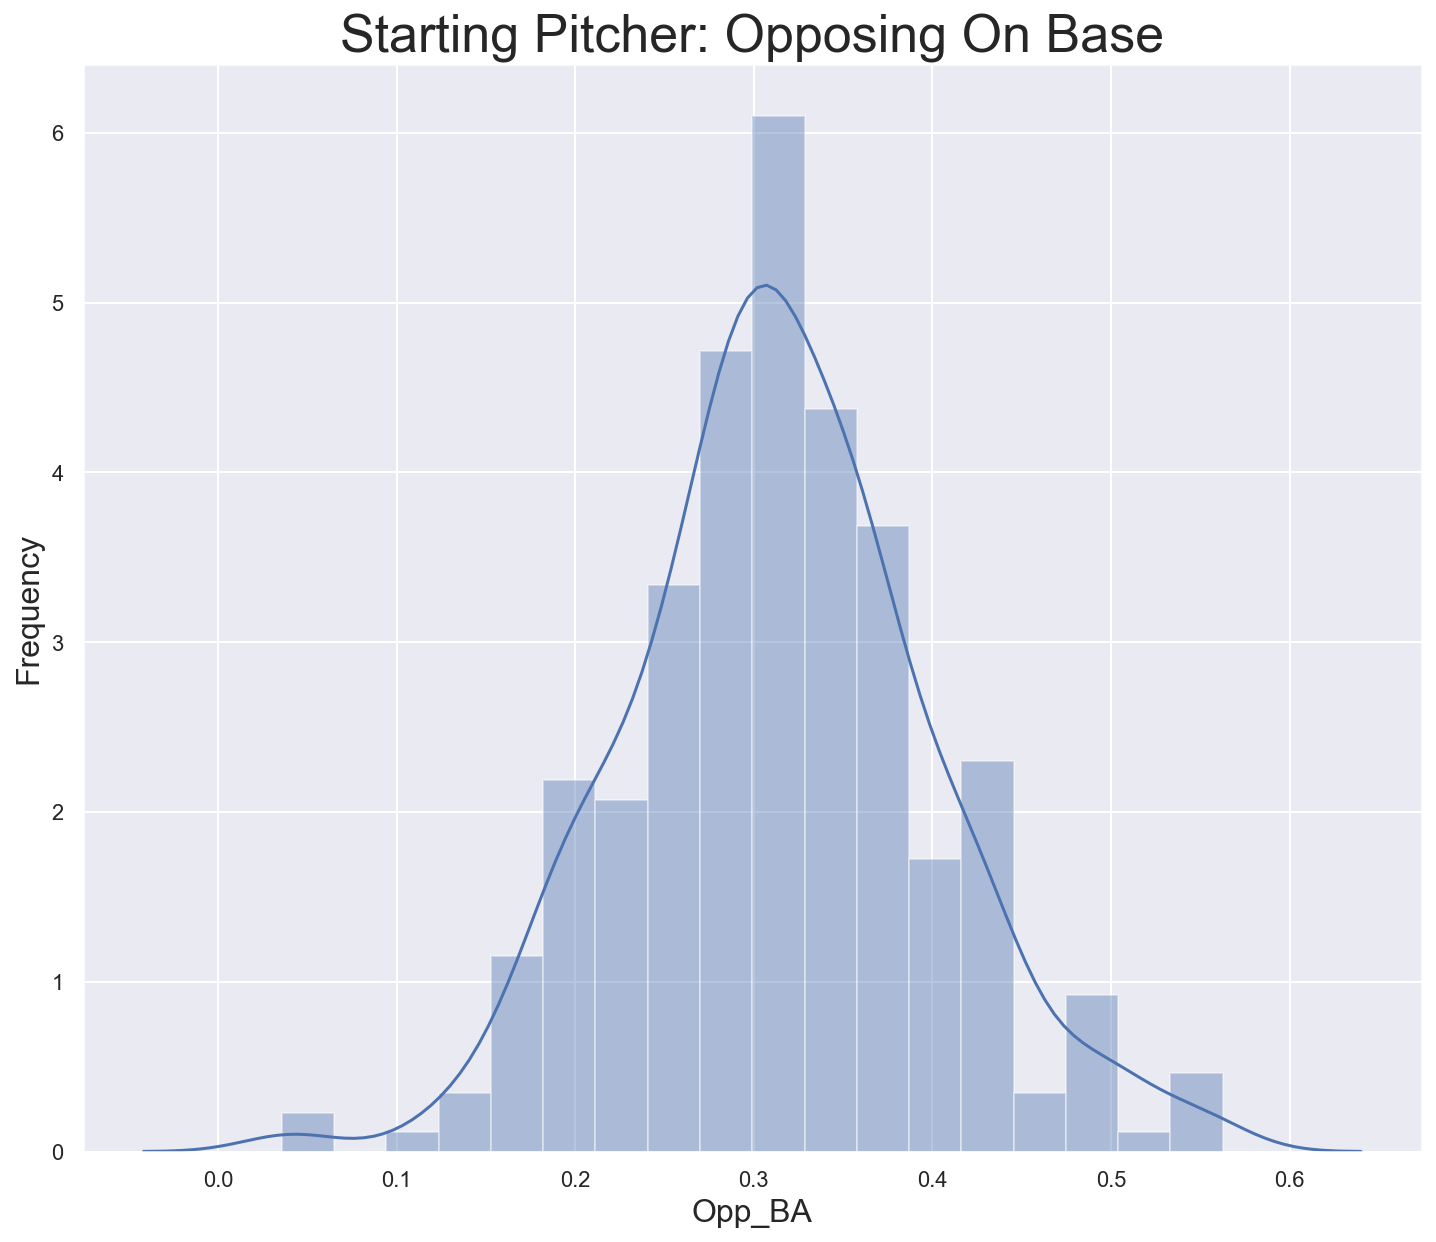

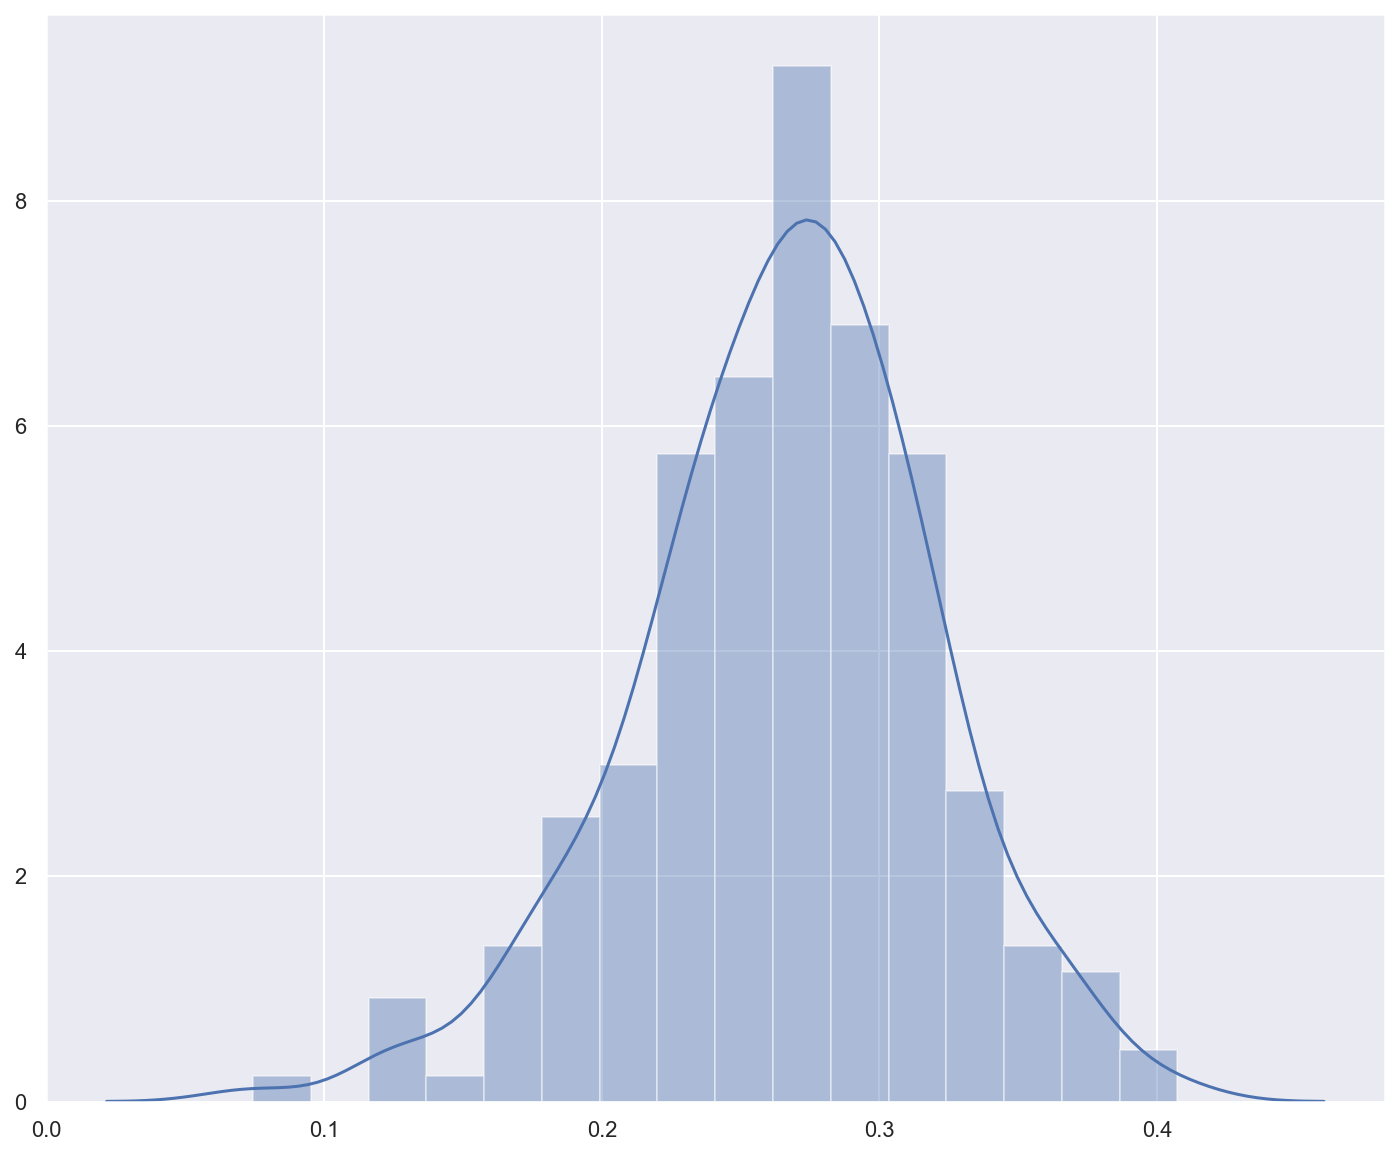

In [165]:
nonZero_homeStarterOBP=[x for x in df['home_starter_OBP'] if x>0]
nonZero_awayStarterOBP=[x for x in df['away_starter_OBP'] if x>0]
nonZero_starterOBP=[item for sublist in [nonZero_awayStarterOBP,nonZero_homeStarterOBP] for item in sublist]

sns.distplot(nonZero_starterOBP)
plt.title('Starting Pitcher: Opposing On Base',fontdict={'fontsize':26})
plt.xlabel('Opp_BA',fontdict={'fontsize':16})
plt.ylabel('Frequency',fontdict={'fontsize':16})
plt.savefig(image_dir+'SP_OBP.jpg')
plt.show()


sns.distplot([x for x in df['home_hitters_SLG_mean'] if x>0])

In [42]:
home_starter_pag = [x for x in df['home_starter_PA_per_Game'] if x>0]
away_starter_pag = [x for x in df['away_starter_PA_per_Game'] if x>0]
starter_pag = [item for sublist in [home_starter_pag,away_starter_pag] for item in sublist]

home_rel_pag = [x for x in df['home_relief_PA_per_Game_mean'] if x>0]
away_rel_pag = [x for x in df['away_relief_PA_per_Game_mean'] if x>0]
rel_pag = [item for sublist in [away_rel_pag,home_rel_pag] for item in sublist]

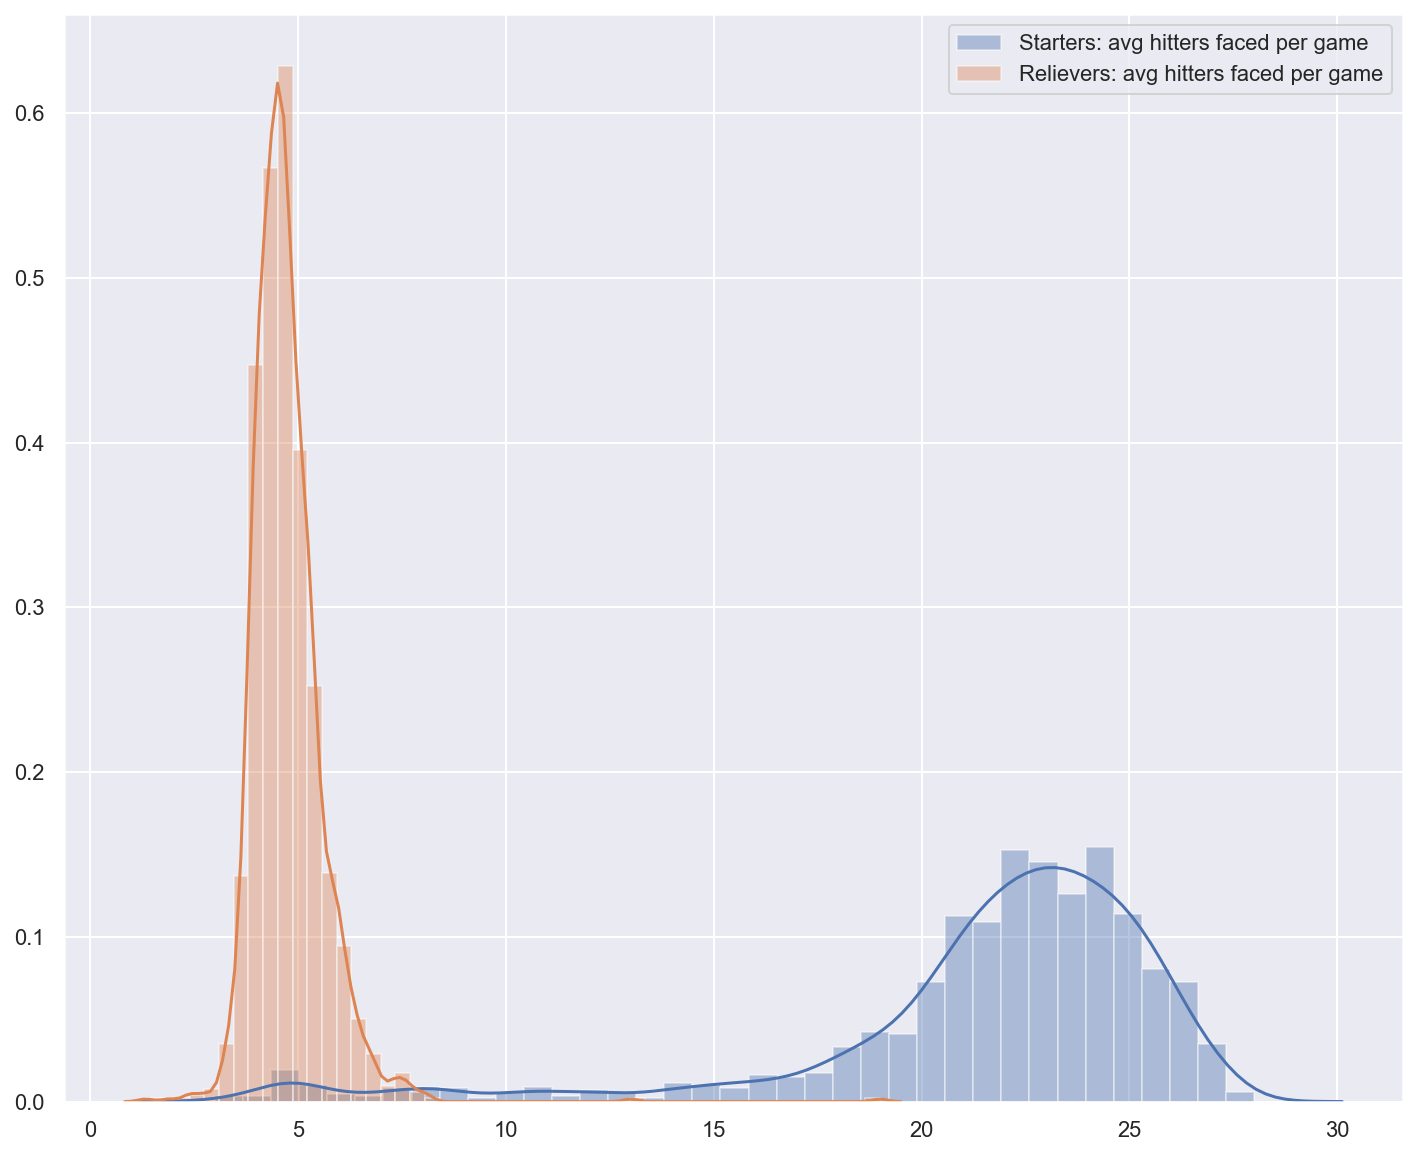

In [45]:
sns.distplot(starter_pag,label='Starters: avg hitters faced per game')
sns.distplot(rel_pag,label='Relievers: avg hitters faced per game')

plt.legend()
plt.savefig(image_dir+"pa_g.jpg")

In [47]:
home_hitters_stats = [x for x in df.columns.tolist() if 'home_hitters' in x and 'std' not in x]

In [48]:
home_hitters_stats

['home_hitters_BA_mean',
 'home_hitters_SLG_mean',
 'home_hitters_OBP_mean',
 'home_hitters_PA_per_Game_mean',
 'home_hitters_GO_O_mean',
 'home_hitters_FO_O_mean',
 'home_hitters_PO_O_mean',
 'home_hitters_LO_O_mean']

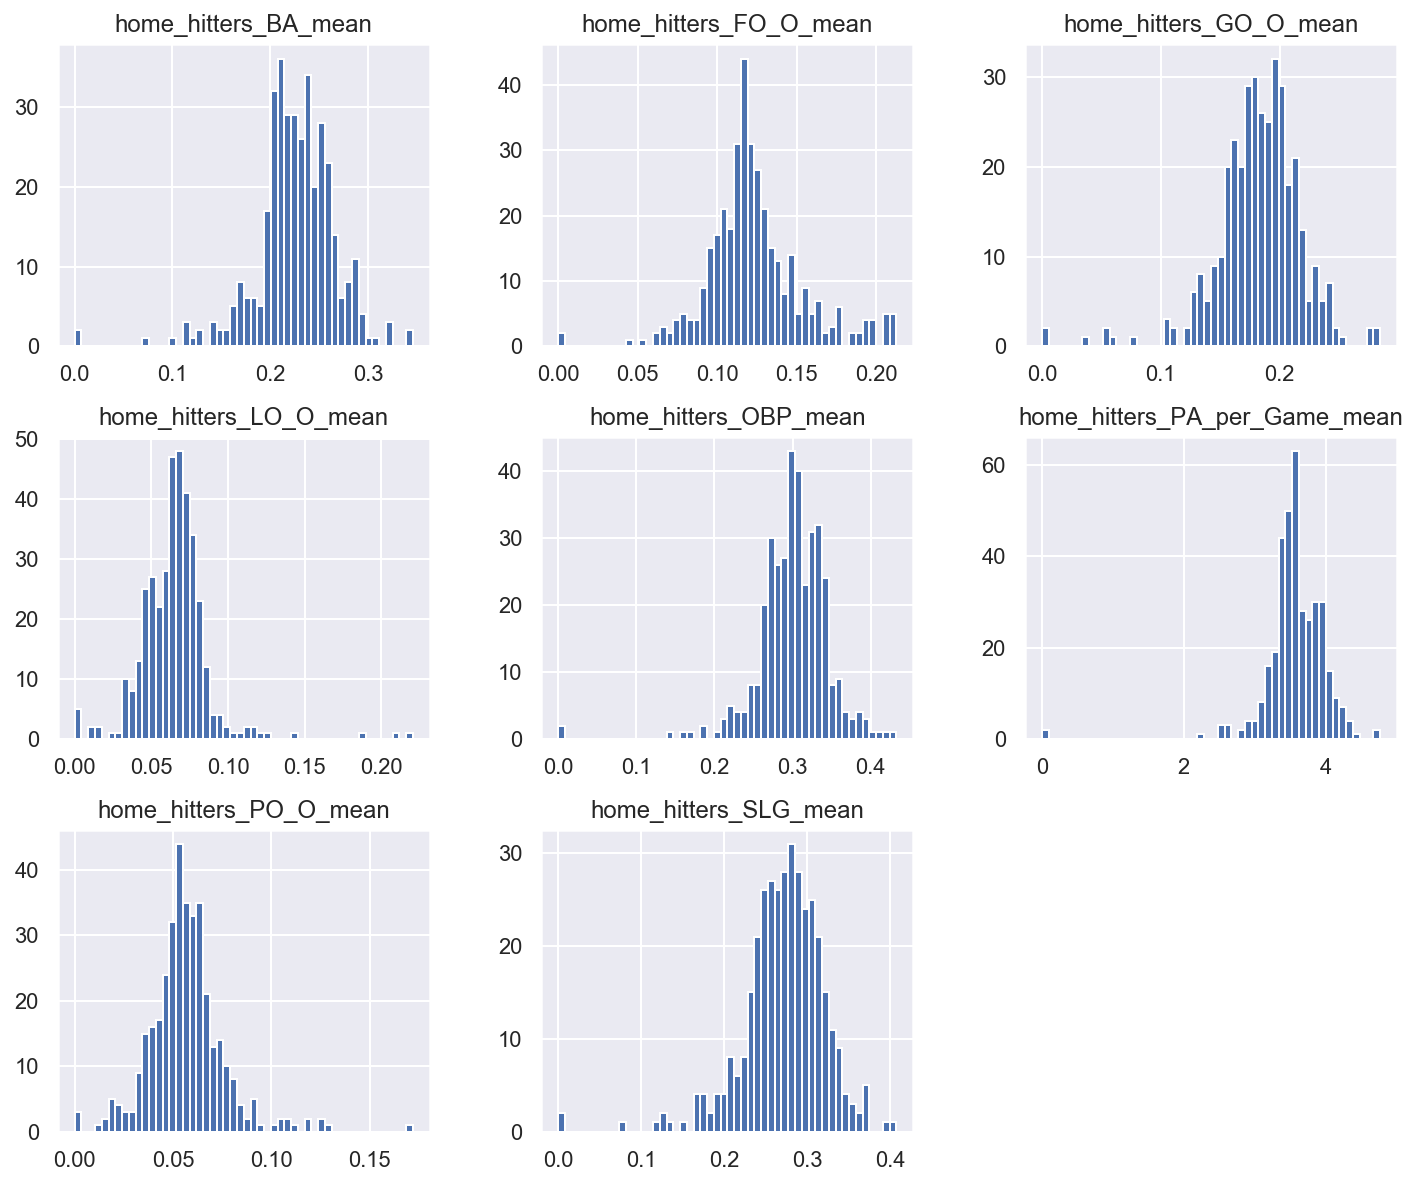

In [178]:
df[home_hitters_stats].hist(bins=50,figsize=(12,10))
plt.savefig(image_dir+'hitter_stats.jpg')
plt.show()
